In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Reading the movie reviews data
review_data = pd.read_csv("IMDB Dataset.csv")
review_data.head(5)
#The dataset contain two columns one for the review text and other for the sentiments(whether people like it or not)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#Getting the info of data using info method
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


The review data contain 50000 entries for both reviews and sentiments
Both reviews and sentiment are non null objects(datatype=object)

This is a dataset for binary sentiment classification

In [4]:
#Now checking for the null value in dataset
review_data.isnull().sum()
#So as we have checked that our dataset contains zero null value for the review and sentiment columns

review       0
sentiment    0
dtype: int64

In [5]:
review_data["review"][1]
#As we can see that our data contains punctuations, html tags, stopwords(not of much importance) so first we need to preprocess our text before feeding it to model(ml or dl)

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [6]:
review_data["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

So as we can see that we have fully balanced dataset(The number of positive examples are equal to the number of negative examples) so we need not to perform any of operating like upsampling,downsampling or use smote algorithm(Borderline smote) for sampling the data.

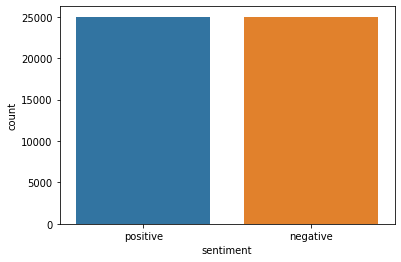

In [7]:
import seaborn as sns
sns.countplot(x="sentiment",data=review_data)

In [8]:
#Now preprocessing our data so that we can remove the html tags,punctuations etc.
def preprocessing_data(sentence):
    #Removing the html tags
    reviews=removing_tags(sentence)
    #Removing every character except the alphabets from a to z(both in lower and upper case)
    reviews=re.sub("[^a-zA-Z]"," ",reviews)
    #As we are removing the apostrophes what actually will happen is that word like sourabh's will get replaces by sourabh and s as separate words
    #Our regular will be creating single words(one character) which are of no importance so we remove them
    #Removing the single character as they are not important
    reviews=re.sub("\s+[a-zA-Z]\s+"," ",reviews)
    #Removing multiple spaces from reviews
    reviews=re.sub("\s+"," ",reviews)
    #Making the text lowercase
    reviews=reviews.lower()
    return reviews

In [9]:
TAR_RE = re.compile(r"<[^>]+>")
#Function for removing tags
def removing_tags(text):
    return TAR_RE.sub("",text)
#The removing tags function simply replaces anything between the < and > with empty space

In [10]:
#Now creating the corpus of text
import nltk
from nltk.corpus import stopwords
corpus = []
sentences = list(review_data["review"])
for sent in sentences:
    corpus.append(preprocessing_data(sent))
print(len(corpus))

50000


In [11]:
#Converting the sentiment column to ones and zeros
y = review_data["sentiment"]
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [12]:
#Splitting the data into train_test_split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(corpus,y,test_size=0.2,random_state=42)

Now lets create our embedding layer which will convert our preprocessed textual data into numeric data
.As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key

We will not be using TF-IDF and count vectorizer as they neither capture positions in text and nor they capture the meaning in text and we will be using Glove pretrained as it capture position in text as well as meaning and also it is trained on a lagre corpus or we can also use fast text for the task

In [13]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
#Here the x_train will contain the index of word from the tokenizer
#After this step x_train and x_test elements will have different lengths depending upon the element size(sentence size)
#So we need to perform padding so as to maintain fixed length of the sequences inx_train and x_test

Using TensorFlow backend.
/home/bluebrain/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bluebrain/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bluebrain/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bluebrain/anaconda3/lib/python3.7/site-pa

In [14]:
#Performing padding on both train and test set and setting size to be 100 of sequence
#And if a sequence has more than maxlen the sequence will be truncated after maxlen
#And if sequence has lesser len than maxlen the sequence will be padded with zeros to make sequence length equal to maxlen
from keras.preprocessing.sequence import pad_sequences
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
x_train = pad_sequences(x_train, padding='post',maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post',maxlen=maxlen)

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros
#We will use GloVe embeddings to create our feature matrix and we will create a dictionary that will contain words as keys and their corresponding embedding list as values
embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
print(embeddings_dictionary["wolf"])

[ 0.073695 -0.033995  0.1175   -0.62037   0.02282  -0.54719   0.17815
 -0.65397  -0.31618  -1.1676   -0.56243   0.65186   0.030927  0.007971
  0.32896   0.56995   0.52986  -0.094319 -0.61012   0.23755  -0.14946
  0.11913   0.059727  0.2162    0.36176   0.93062  -0.92673   0.36767
  0.059147  0.3082    0.17613   0.026632 -0.45234   0.27703   0.18998
  0.26091  -0.026159  0.40505   1.3821    0.075603 -0.076359  0.19258
 -0.56764   0.71397   0.10174  -0.086357 -0.15671  -0.53022  -0.1063
  0.32784  -0.066472 -0.5361   -0.13433   0.61026  -0.21795  -1.4938
  0.14192   0.12176   0.38179   0.35812   0.76489   0.69533  -0.11341
 -0.055595  1.0308   -0.084502  0.20062   0.57746   0.15714   0.57664
 -0.26053  -0.39672  -0.24518   0.042514 -0.1222    0.082824 -0.56566
 -0.64397  -0.28528   0.44216  -0.17003  -0.16883  -0.34474  -0.20922
 -0.38548   0.072244 -0.096744 -0.53621   0.54864   0.50515   0.45365
 -0.82197   0.51722   0.36603   0.040918 -0.20183  -0.92315   0.47886
  0.6582   -0.27819 ]

Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus

In [17]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
#Now performing the classification task
#Here first we are going to take a simple neural network(yhen proceed to advance)
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

model = Sequential()
#For a deep neural network the input layer can be TF-IDF, word embeddings etc
#We are not training our own embeddings and using the GloVe embedding
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_______________________________________________

In [20]:
history = model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
#As our accuracy is still increasing and loss is coming down, we can icrease the number of layers in our neural network and see how it is helping in getting model accurate
#But better will be to use RNN's,CNN's,RCNN,Attention network and other architectures that work good for such problem

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 29s 892us/step - loss: 0.7013 - acc: 0.6144 - val_loss: 0.5701 - val_acc: 0.7181
Epoch 2/6
32000/32000 [==============================] - 26s 804us/step - loss: 0.5680 - acc: 0.7004 - val_loss: 0.5439 - val_acc: 0.7284
Epoch 3/6
32000/32000 [==============================] - 27s 849us/step - loss: 0.5305 - acc: 0.7224 - val_loss: 0.5225 - val_acc: 0.7365
Epoch 4/6
32000/32000 [==============================] - 28s 881us/step - loss: 0.4876 - acc: 0.7542 - val_loss: 0.5301 - val_acc: 0.7319
Epoch 5/6
32000/32000 [==============================] - 27s 845us/step - loss: 0.4747 - acc: 0.7596 - val_loss: 0.5437 - val_acc: 0.7322
Epoch 6/6
32000/32000 [==============================] - 30s 930us/step - loss: 0.4618 - acc: 0.7605 - val_loss: 0.5261 - val_acc: 0.7371


In [21]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy:", score[1])
#As our accuracy so we need to use some other architecture to improve accuracy and get a good model

10000/10000 [==============================] - 2s 170us/step
Test Accuracy: 0.7396


Convolutional neural networks(for hierarchical document classification)have been found to work well with text data as well.Though text data is one-dimensional,we can use 1D convolutional neural networks to extract features from our data

Although originally was built for image processing with architecture similar to that of the the visual cortex,CNNs have also been effectively used for text classification and related task

Problem of CNN using with text is the number of channels,Sigma(size of the feature space).This might be very large (nK-n a large number take forexample 80),for text but for images this is less of a problem (only 3 channels of RGB).This basically means the dimensionality of the CNN for text is very high.

Here we will be using convolutonal 1d

In [24]:
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers.embeddings import Embedding
model1 = Sequential()
embedding_layer1 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer1)
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(Dropout(0.3))
model1.add(MaxPooling1D(5))
model1.add(Conv1D(128, 5, activation='relu'))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(5))
model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model1.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
dropout_7 (Dropout)          (None, 96, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 15, 128)           82048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 128)           0         
_______________________________________________

In [25]:
history = model1.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model1.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 29s 909us/step - loss: 0.6120 - acc: 0.6583 - val_loss: 0.5060 - val_acc: 0.7804
Epoch 2/6
32000/32000 [==============================] - 20s 622us/step - loss: 0.4584 - acc: 0.7853 - val_loss: 0.4593 - val_acc: 0.8085
Epoch 3/6
32000/32000 [==============================] - 20s 627us/step - loss: 0.4197 - acc: 0.8079 - val_loss: 0.4511 - val_acc: 0.8204
Epoch 4/6
32000/32000 [==============================] - 21s 669us/step - loss: 0.3968 - acc: 0.8210 - val_loss: 0.4240 - val_acc: 0.8271
Epoch 5/6
32000/32000 [==============================] - 22s 700us/step - loss: 0.3666 - acc: 0.8364 - val_loss: 0.3994 - val_acc: 0.8197
Epoch 6/6
10000/10000 [==============================] - 2s 192us/step
Test Accuracy: 0.8313


In [31]:
#Using recurrent neural network for classification as basically neural network works well with sequential data
#As text is also a sequential data so the best choice is to use recurrent neural network
from keras.layers import LSTM,GRU
model2 = Sequential()
embedding_layer2 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer2)
model2.add(GRU(256,return_sequences = True,recurrent_dropout = 0.2))
model2.add(Dropout(0.4))
model2.add(GRU(128,return_sequences = True,recurrent_dropout = 0.2))
model2.add(Dropout(0.4))
model2.add(GRU(64,recurrent_dropout = 0.2))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation="relu"))
model2.add(Dense(128, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
gru_9 (GRU)                  (None, 100, 256)          274176    
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
gru_10 (GRU)                 (None, 100, 128)          147840    
_________________________________________________________________
dropout_18 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
__________

In [32]:
history = model2.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model2.evaluate(x_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 177s 6ms/step - loss: 0.5435 - acc: 0.7182 - val_loss: 0.4196 - val_acc: 0.8055
Epoch 2/6
32000/32000 [==============================] - 157s 5ms/step - loss: 0.4119 - acc: 0.8165 - val_loss: 0.3828 - val_acc: 0.8376
Epoch 3/6
32000/32000 [==============================] - 154s 5ms/step - loss: 0.3732 - acc: 0.8359 - val_loss: 0.3627 - val_acc: 0.8425
Epoch 4/6
32000/32000 [==============================] - 160s 5ms/step - loss: 0.3579 - acc: 0.8458 - val_loss: 0.3486 - val_acc: 0.8481
Epoch 5/6
32000/32000 [==============================] - 155s 5ms/step - loss: 0.3218 - acc: 0.8616 - val_loss: 0.3296 - val_acc: 0.8585
Epoch 6/6
10000/10000 [==============================] - 20s 2ms/step


In [33]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.8631


Using RCNN for the task of classification

The main idea of this technique is capturing contextual information with the recurrent structure and constructing the representation of text using a convolutional neural network.This architecture is a combination of RNN and CNN to use advantages of both technique in a model

In [41]:
model3 = Sequential()
embedding_layer3 = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model3.add(embedding_layer3)
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(Dropout(0.3))
model3.add(MaxPooling1D(5))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(Dropout(0.5))
model3.add(MaxPooling1D(5))
model3.add(LSTM(256, return_sequences=True, recurrent_dropout=0.2))
model3.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2))
model3.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2))
model3.add(LSTM(32, recurrent_dropout=0.2))
model3.add(Dense(1024,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(512,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(256,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(128,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(1,activation="sigmoid"))   
model3.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
dropout_32 (Dropout)         (None, 96, 128)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 15, 128)           82048     
_________________________________________________________________
dropout_33 (Dropout)         (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 3, 128)            0         
__________

In [42]:
history = model3.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model3.evaluate(x_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 39s 1ms/step - loss: 0.6905 - acc: 0.5135 - val_loss: 0.6537 - val_acc: 0.6499
Epoch 2/6
32000/32000 [==============================] - 29s 901us/step - loss: 0.5210 - acc: 0.7521 - val_loss: 0.4508 - val_acc: 0.8004
Epoch 3/6
32000/32000 [==============================] - 27s 857us/step - loss: 0.4354 - acc: 0.8036 - val_loss: 0.4767 - val_acc: 0.7751
Epoch 4/6
32000/32000 [==============================] - 27s 842us/step - loss: 0.3987 - acc: 0.8211 - val_loss: 0.3832 - val_acc: 0.8280
Epoch 5/6
32000/32000 [==============================] - 27s 847us/step - loss: 0.3815 - acc: 0.8321 - val_loss: 0.3695 - val_acc: 0.8346
Epoch 6/6
10000/10000 [==============================] - 4s 369us/step


In [43]:
print("Test Accuracy:", score[1])

Test Accuracy: 0.8381


Using the above models we got best accuracy with Recurrent Neural Network

All the accuray stuff depends upon the architecture, the number of layers used, the number of neuron used in each layer, the hyperparameters etc

We can also use RMDL(Random Multimodel deep learning),HDLTex(Hierarchical deep learning for text).